# Cabeçalho

In [1]:
from google.colab import drive
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
drive.mount('/content/drive', force_remount=True)

# FOLDERNAME = 'repo'
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.append('/content/drive/My Drive/repo/codes')
from utils import video_utils

Mounted at /content/drive


In [3]:
STRING_BODY = 'frame_{}.jpeg'
IMAGE_PATH = '/content/drive/My Drive/repo/dataFrame/all_frames'
DATA_FRAME_PATH = '/content/drive/My Drive/repo/dataFrame'
NEW_PATH = '/content/drive/My Drive/repo/dataFrame/frames_s_100/'

# Imagens

In [4]:
image1 = cv2.imread(NEW_PATH +'frame_0001.jpeg')
image2 = cv2.imread(NEW_PATH + 'frame_0075.jpeg')

# Definindo Funções

In [5]:
def cumulative_sum (data_frame_path, image_path, translation = 100):
  df = pd.read_csv(data_frame_path)
  x = df['x']
  y = df['y']
  c = df['c']

  frame = np.array(Image.open(image_path + '/frame_0001.jpeg'))
  translation = frame.shape[0] - 100

  counter = 0
  aux = 0
  while aux < translation:
    if (abs(df['y'][counter]) > abs(df['x'][counter])):
      aux += abs(df['y'][counter])
    counter += 1
  return aux, counter

In [6]:
def concatenate_images_vertical(image1, image2):
    # Obter as larguras das duas imagens
    width1, width2 = image1.shape[1], image2.shape[1]

    # Verificar qual das duas imagens é mais larga e ajustar a outra imagem para a mesma largura
    if width1 < width2:
        image1 = cv2.resize(image1, (width2, int(image1.shape[0] * width2 / width1)))
    elif width2 < width1:
        image2 = cv2.resize(image2, (width1, int(image2.shape[0] * width1 / width2)))

    # Concatenar as duas imagens verticalmente
    concatenated_image = np.vstack((image1, image2))

    return concatenated_image

In [7]:
def convolve_with_sine_kernel(image, side = 'up', translation = 100):

  rows, columns, channel = image.shape

  if side == 'up':
    for_condition = [range(channel), range(0, translation), range(columns)]
    x = np.linspace(0, np.pi/2, translation)
    mask = np.sin(x)**2
  elif side == 'low':
    for_condition = [range(channel), range(rows - translation, rows), range(columns)]
    x = np.linspace(np.pi/2, np.pi, translation)
    mask = np.sin(x)**2
  elif side == 'left':
    for_condition = [range(channel), range(rows), range(0, translation)]
    x = np.linspace(0, np.pi/2, translation)
    mask = np.sin(x)**2
  elif side == 'right':
    for_condition = [range(channel), range(rows), range(columns - translation, columns)]
    x = np.linspace(np.pi/2, np.pi, translation)
    mask = np.sin(x)**2
  else:
    return False

  x = np.linspace(0, np.pi, image1.shape[0])
  y = np.sin(x)**2

  convolved_image = np.copy(image)

  for k in for_condition[0]:
    for i in for_condition[1]:
      for j in for_condition[2]:
        if side == 'up':
          convolved_image[i][j][k] = convolved_image[i][j][k]*mask[i]
        elif side == 'low':
          convolved_image[i][j][k] = convolved_image[i][j][k]*mask[i - rows + translation]
        elif side == 'right':
          convolved_image[i][j][k] = convolved_image[i][j][k]*mask[j - columns + translation]
        elif side == 'left':
          convolved_image[i][j][k] = convolved_image[i][j][k]*mask[j]


  return convolved_image

In [16]:
def truncate_images(image1, image2, axis = 'vertical', translation = 100):

  rows, columns, channel = image1.shape

  if axis == 'vertical':
    for_condition = [[range(channel), range(0, translation), range(columns)],
                     [range(rows-translation, rows), range(columns)]]
    truncate_image = np.vstack((image2[:rows - translation], image1))
  elif axis == 'horizontal':
    for_condition = [[range(channel), range(rows), range(0, translation)],
                     [range(rows), range(columns-translation, columns)]]
  else:
    return 1

  for k in for_condition[0][0]:
    for i in for_condition[0][1]:
      for j in for_condition[0][2]:
        for i2 in for_condition[1][0]:
          for j2 in for_condition[1][1]:
            truncate_image[i][j][k] = image1[i][j][k] + image2[i2][j2][k]

  return truncate_image

# TESTES

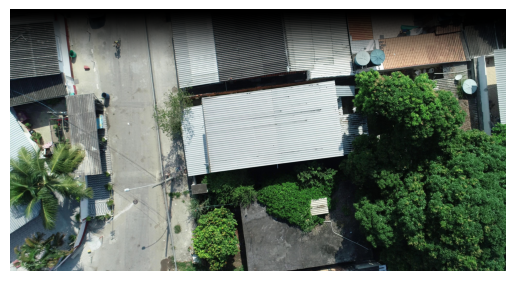

In [10]:
new_image1 = convolve_with_sine_kernel(image1, 'up', 500)
plt.imshow(cv2.cvtColor(new_image1,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

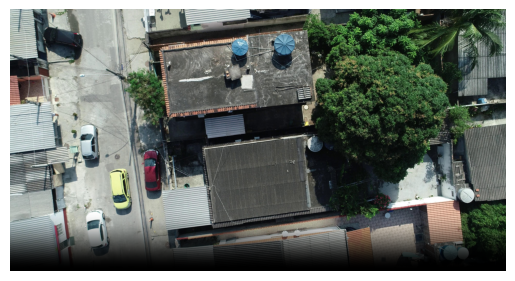

In [11]:
new_image2 = convolve_with_sine_kernel(image2, 'low', 500)
plt.imshow(cv2.cvtColor(new_image2,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
truncate_images(new_image1, new_image2)

In [ ]:
def truncate_images(image1, image2, axis = 'vertical', translation = 100):

  rows, columns, channel = image1.shape

  if axis == 'vertical':
    for_condition = [[range(channel), range(0, translation), range(columns)],
                     [range(rows-translation, rows), range(columns)]]
    truncate_image = np.vstack((image2[:rows - translation], image1))
  elif axis == 'horizontal':
    for_condition = [[range(channel), range(rows), range(0, translation)],
                     [range(rows), range(columns-translation, columns)]]
  else:
    return 1

  truncate_image[rows - translation: rows] = image1[0:translation] + image2[rows-translation:rows]

  return truncate_image